In [1]:
import pandas as pd
import seaborn as sns
from collections import Counter
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
from sklearn.ensemble import IsolationForest

### The following plot illustrates the number of vehicles per hour recorded over the course of a single day.

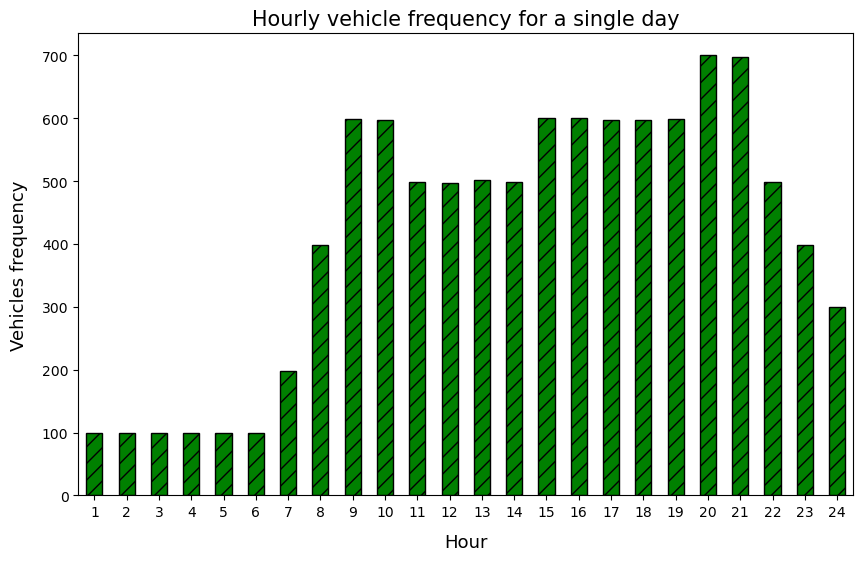

In [2]:
tree =ET.parse(r"C:\LiftC project\last\linz_sumo_scenario-master\linz_sumo_scenario-master\scenarios\linz_10000\routes.rou.xml")
root = tree.getroot()

all_vehicles = []
for vehicle in root.findall("vehicle"):
    vehicle_id = vehicle.get("id")
    departure_time = float(vehicle.get("depart"))
    edges_id = vehicle.find("route").get("edges").split()
    all_vehicles.append({"vehicle_id": vehicle_id, "departure_time": departure_time, "edges_id": edges_id})

all_vehicles_df = pd.DataFrame(all_vehicles)
all_vehicles_df["route_length"] = all_vehicles_df["edges_id"].apply(len)
all_vehicles_df["hour"] = all_vehicles_df["departure_time"].apply(lambda x: int(x // 3600) + 1)
all_vehicles_df.to_csv(r"C:\Users\amirhesam\Desktop\code for liftc\Analysis_based_on_routes_file.csv", index = True, header = True)

vehicles_per_hour = all_vehicles_df.groupby("hour").size()
vehicles_per_hour.plot(kind = "bar", color = "green", edgecolor = "black", hatch = "//", figsize = (10, 6))
plt.title("Hourly vehicle frequency for a single day", fontsize = 15)
plt.xticks(rotation = 360)
plt.xlabel("Hour", fontsize = 13, labelpad = 10)
plt.ylabel("Vehicles frequency", fontsize = 13, labelpad = 10)
plt.show()

### The plot below illustrates the IDs and frequencies of the 10 most frequent edges on the map for a single day.

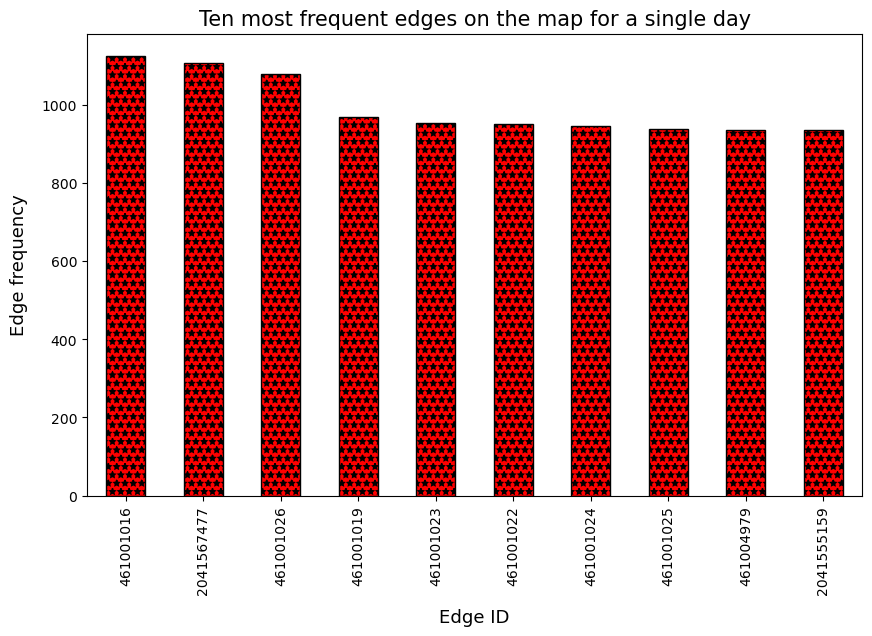

In [3]:
all_edges = [id for edge_id in all_vehicles_df["edges_id"] for id in edge_id]
all_edges_frequency = Counter(all_edges)

all_edges_frequency_df = pd.DataFrame(all_edges_frequency.items(), columns = ["edge", "frequency"]).sort_values(by = "frequency", ascending = False)
all_edges_frequency_df.head(10).plot(kind = "bar", color = "red", edgecolor = "black", x = "edge", y = "frequency",
                                     figsize = (10, 6), legend = False, hatch = "**")
plt.title("Ten most frequent edges on the map for a single day", fontsize = 15)
plt.xlabel("Edge ID", fontsize = 13, labelpad = 10)
plt.ylabel("Edge frequency", fontsize = 13, labelpad = 10)
plt.show()

### The plot below shows the IDs and frequencies of the primary nearest edges to each refueling station on the map over the course of a single day.

- We can also take a screenshot from the map of Linz on netedit or SUMO and draw a circel around each station and write its ID beside that.

In [4]:
# I considered name for the stations based on their edges from "S1" to "S16".
# nearest_edges_stations = {"E46": "S16",
#                "E43": "S15",
#                "E40": "S14",
#                "E37": "S13",
#                "E34": "S12",
#                "E31": "S11",
#                "E28": "S10",
#                "E25": "S9",
#                "E22": "S8",
#                "E19": "S7",
#                "E16": "S6",
#                "E13": "S5",
#                "E10": "S4",
#                "E8": "S3",
#                "E5": "S2",
#                "E1": "S1"
#                }

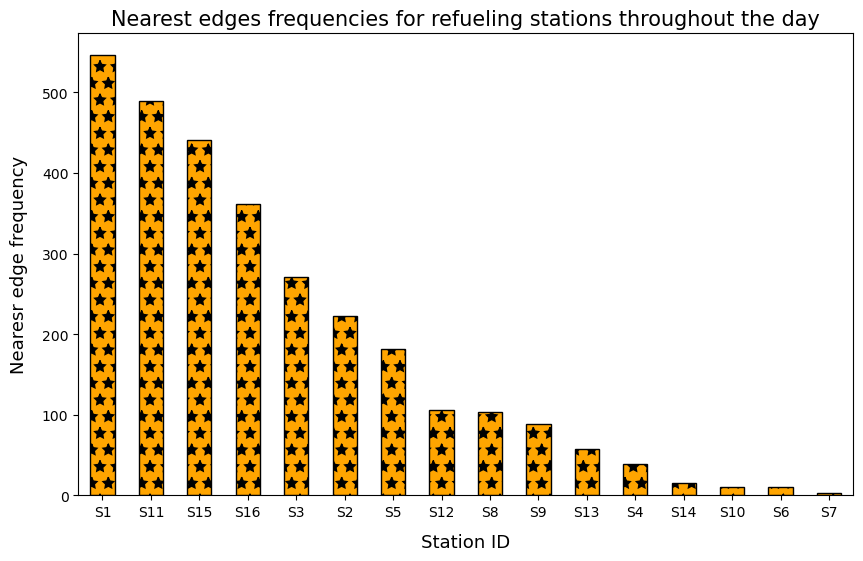

In [5]:
nearest_edges_stations = {"S16": ["304018259"],
               "S15": ["304272798"],
               "S14": ["304082094"],
               "S13": ["304029426"],
               "S12": ["304030226"],
               "S11": ["2041891213"],
               "S10": ["304173393#1.7"],
               "S9": ["304218002#1"],
               "S8": ["304081680#1"],
               "S7": ["304080798#1"],
               "S6": ["304080725#1"],
               "S5": ["304021458#1"],
               "S4": ["304079515"],
               "S3": ["304028057"],
               "S2": ["304016326#1"],
               "S1": ["304109524"]
               }

reversed_nearest_edges_stations = {str(values): keys for keys, values in nearest_edges_stations.items()}

all_edges_of_stations = [id for edges in nearest_edges_stations.values() for id in edges]

all_edges_filterd = [id for edge_id in all_vehicles_df["edges_id"] for id in edge_id if id in all_edges_of_stations]
all_edges_of_stations_freq = Counter(all_edges_filterd)
all_edges_of_stations_freq = {reversed_nearest_edges_stations[f"['{keys}']"]: values for keys, values in all_edges_of_stations_freq.items()}

all_edges_of_stations_freq_df = pd.DataFrame(all_edges_of_stations_freq.items(), columns = ["edge", "frequency"]).sort_values(by = "frequency", ascending = False)
all_edges_of_stations_freq_df.head(16).plot(kind = "bar", color = "orange", edgecolor = "black", x = "edge", y = "frequency",
                                     figsize = (10, 6), legend = False, hatch = "*")
plt.title("Nearest edges frequencies for refueling stations throughout the day", fontsize = 15)
plt.xticks(rotation = 360)
plt.xlabel("Station ID", fontsize = 13, labelpad = 10)
plt.ylabel("Nearesr edge frequency", fontsize = 13, labelpad = 10)
plt.show()


### The plot in the below shows the hourly traffic volume for the top 10 most frequently used road segments in a single day.

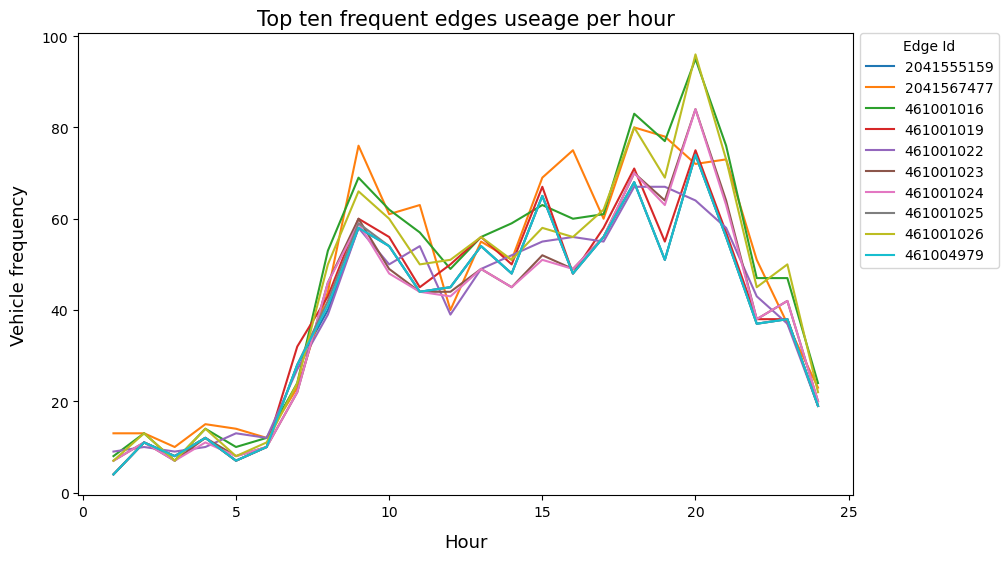

In [6]:
top_ten_frequent_edges = [edge for edge, frequency in all_edges_frequency.most_common(10)]

top_ten_frequent_edges_hour = []
for index, row in all_vehicles_df.iterrows():
    for edge_id in row["edges_id"]:
        if edge_id in top_ten_frequent_edges:
            top_ten_frequent_edges_hour.append({"hour":row["hour"], "edge_id": edge_id})

top_ten_frequent_edges_hour_df = pd.DataFrame(top_ten_frequent_edges_hour)
top_ten_frequent_edges_hour_size = top_ten_frequent_edges_hour_df.groupby(["hour", "edge_id"]).size().unstack(fill_value = 0)
top_ten_frequent_edges_hour_size.plot(kind = "line", figsize = (10, 6))
plt.title("Top ten frequent edges useage per hour", fontsize = 15)
plt.xlabel("Hour", fontsize = 13, labelpad = 10)
plt.ylabel("Vehicle frequency", fontsize = 13, labelpad = 10)
plt.legend(title = "Edge Id", loc = 0, bbox_to_anchor = (1, 1.015))
plt.show()

### The plot below shows the hourly traffic volume for the nearest edges to the stations over the course of a single day.

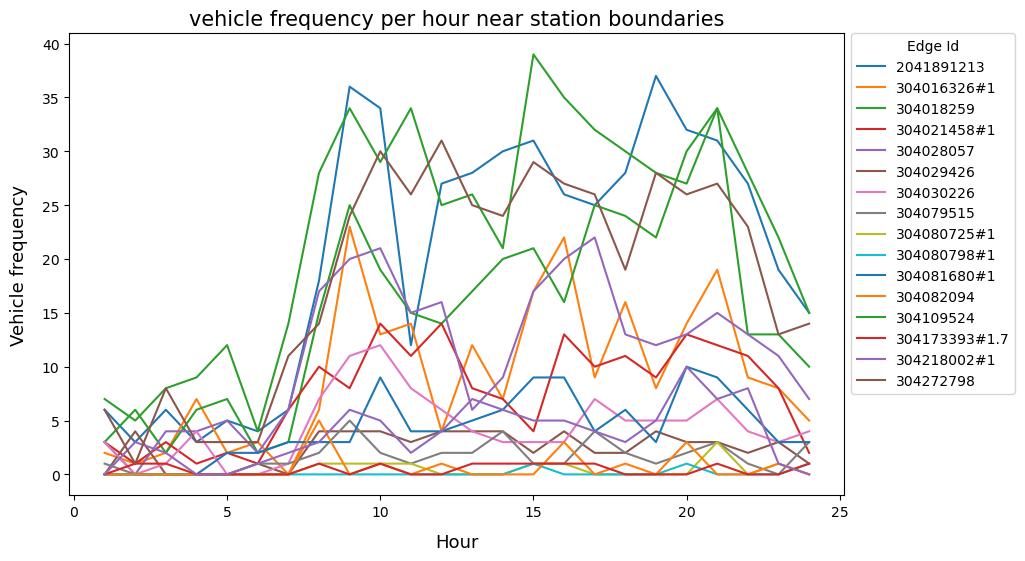

In [7]:
nearest_edges_stations_hour = []
for index, row in all_vehicles_df.iterrows():
    for edge_id in row["edges_id"]:
        if edge_id in all_edges_of_stations:
            nearest_edges_stations_hour.append({"hour":row["hour"], "edge_id": edge_id})

nearest_edges_stations_hour_df = pd.DataFrame(nearest_edges_stations_hour)
top_twenty_frequent_edges_hour_size = nearest_edges_stations_hour_df.groupby(["hour", "edge_id"]).size().unstack(fill_value = 0)
top_twenty_frequent_edges_hour_size.plot(kind = "line", figsize = (10, 6))
plt.title("vehicle frequency per hour near station boundaries", fontsize = 15)
plt.xlabel("Hour", fontsize = 13, labelpad = 10)
plt.ylabel("Vehicle frequency", fontsize = 13, labelpad = 10)
plt.legend(title = "Edge Id", loc = 0, bbox_to_anchor = (1, 1.015))
plt.show()

### The following plot shows the number of edges that vehicles changed during their travel. As each vehicle has a route that consists of sequence of edge IDS, I  decide to visulize this to see the most common behavior of drivers, how much they changed their directions or not.

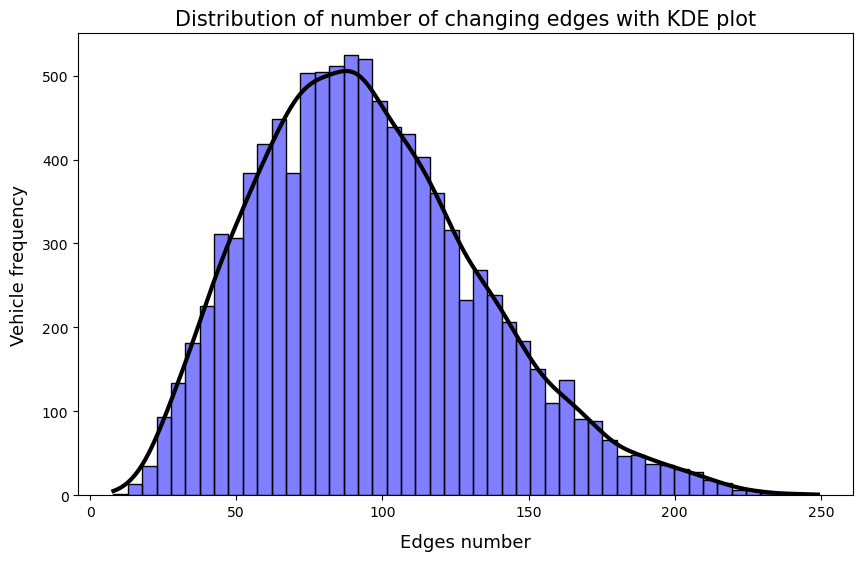

In [8]:
plt.figure(figsize=(10, 6))

ax = sns.histplot(all_vehicles_df["route_length"], color = "blue", edgecolor = "black", kde = True,
                  line_kws = {"linewidth": 3})

ax.lines[0].set_color("black")
plt.title("Distribution of number of changing edges with KDE plot", fontsize = 15)
plt.xlabel("Edges number", fontsize = 13, labelpad = 10)
plt.ylabel("Vehicle frequency", fontsize = 13, labelpad = 10)
plt.show()

### In the following plot, I vizualized the anomalies in the number of the edges per vehivle to see which numbers are outliers somehow.

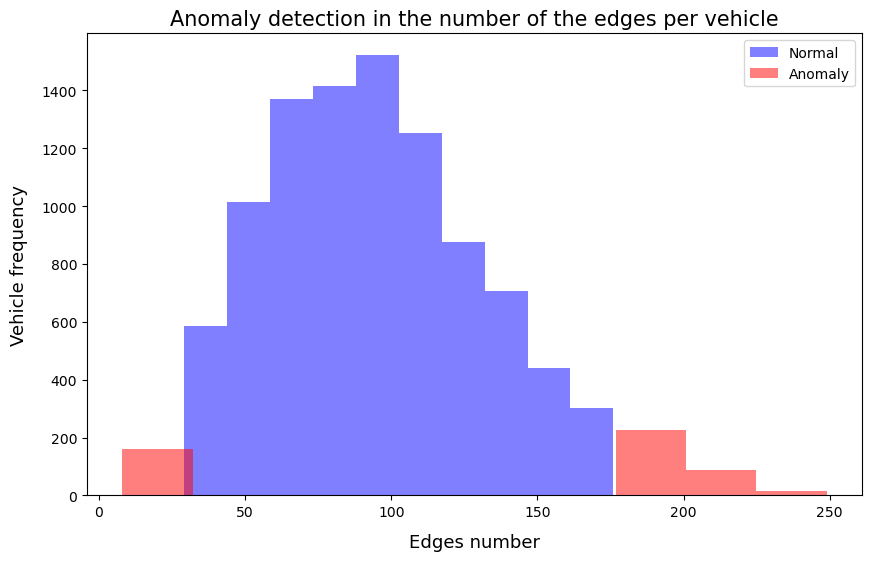

In [11]:
anomaly_features = all_vehicles_df[["route_length"]]
iso_forest = IsolationForest(contamination = 0.05, random_state = 72)
all_vehicles_df["anomaly"] = iso_forest.fit_predict(anomaly_features)
anomalies = all_vehicles_df[all_vehicles_df["anomaly"] == -1]
normal = all_vehicles_df[all_vehicles_df["anomaly"] == 1]

normal["route_length"].plot(kind = "hist", alpha = 0.5, label = "Normal", color = "blue", figsize=(10, 6))
anomalies["route_length"].plot(kind = "hist", alpha = 0.5, label = "Anomaly", color = "red", figsize=(10, 6))
plt.title("Anomaly detection in the number of the edges per vehicle", fontsize = 15)
plt.xlabel("Edges number", fontsize = 13, labelpad = 10)
plt.ylabel("Vehicle frequency", fontsize = 13, labelpad = 10)
plt.legend()
plt.show()